In [23]:
import os
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW

from FeatureAcquisition import FeatureAcquisition
from Predictor import Predictor
from Generators import GaussianSampler

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from PartialVAE import PartialVAE

In [24]:
# 하나의 샘플에서 k개가 관측되었다고 가정
# k개의 관측을 임의로 배정

def sample_mask_uniform_K_per_sample(bs, d, min_K, max_K): # batch size, feature 개수, 최소 관측 샘플 수, 최대 관측 샘플 수
    m = np.zeros((bs, d), dtype=np.float32)
    Ks = np.random.randint(min_K, max_K+1, size=(bs,))
    for i, K in enumerate(Ks): # Ks의 index와 해당 index의 값
        idx = np.random.choice(d, size=K, replace=False)
        m[i, idx] = 1.0
    return m

In [25]:
def set_seed(seed):
    np.random.seed(seed)                 # numpy random
    torch.manual_seed(seed)              # CPU의 torch seed

## CUBE Experiments

In [26]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data", "cube")

dataset_dict = torch.load(f"{DATA_DIR}/dataset_dict.pt")
M_train = torch.load(f"{DATA_DIR}/M_train.pt").float()
M_val = torch.load(f"{DATA_DIR}/M_val.pt").float()
M_test = torch.load(f"{DATA_DIR}/M_test.pt").float()
X_train = torch.load(f"{DATA_DIR}/X_train_cdf.pt").float()
X_val   = torch.load(f"{DATA_DIR}/X_val_cdf.pt").float()
y_train = torch.load(f"{DATA_DIR}/y_train.pt").long()
y_val   = torch.load(f"{DATA_DIR}/y_val.pt").long()
X_test = torch.load(f"{DATA_DIR}/X_test_cdf.pt").float()
y_test = torch.load(f"{DATA_DIR}/y_test.pt").long()

In [ ]:
def train_predictor(
    X_train, y_train, X_val, y_val, X_test, y_test,
    feature_dim=20,
    num_classes=8,
    hidden_dim=128,
    batch_size=256,
    lr=1e-3,
    weight_decay=1e-4,
    epochs=50,
    device=None
):
    """
    Predictor 모델을 학습하고, 마지막 epoch의 validation/test accuracy를 반환하는 함수.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # === 모델, 옵티마이저, 로스 정의 ===
    predictor = Predictor(feature_dim=feature_dim, num_classes=num_classes, hidden_dim=hidden_dim).to(device)
    optimizer = AdamW(predictor.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # === 데이터로더 ===
    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

    # === 학습 루프 ===
    for epoch in range(epochs):
        predictor.train()
        total_loss = 0.0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            mb = torch.ones_like(xb, dtype=torch.float32, device=device)  # 모든 feature 관측

            logits = predictor(xb, mb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        predictor.eval()
        with torch.no_grad():
            # === Validation ===
            xv, yv = X_val.to(device), y_val.to(device)
            mv = torch.ones_like(xv, dtype=torch.float32, device=device)
            probs_val = predictor(xv, mv)
            preds_val = probs_val.argmax(dim=-1)
            acc_val = (preds_val == yv).float().mean().item()

            # === Test ===
            xt, yt = X_test.to(device), y_test.to(device)
            mt = torch.ones_like(xt, dtype=torch.float32, device=device)
            probs_test = predictor(xt, mt)
            preds_test = probs_test.argmax(dim=-1)
            acc_test = (preds_test == yt).float().mean().item()

        print(f"[Epoch {epoch+1:02d}] val acc / {acc_val:.4f} | test acc / {acc_test:.4f}")

    # === 마지막 epoch의 val/test accuracy 반환 ===
    return acc_val, acc_test

val_acc, test_acc = train_predictor(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    feature_dim=20,
    num_classes=8,
    hidden_dim=128,
    batch_size=256,
    lr=1e-3,
    weight_decay=1e-4,
    epochs=50
)

print(f"최종 결과 → val acc: {val_acc:.4f}, test acc: {test_acc:.4f}")

[Epoch 01] val acc / 0.9285 | test acc / 0.9242
[Epoch 02] val acc / 0.9344 | test acc / 0.9291
[Epoch 03] val acc / 0.9402 | test acc / 0.9372
[Epoch 04] val acc / 0.9430 | test acc / 0.9415
[Epoch 05] val acc / 0.9481 | test acc / 0.9457
[Epoch 06] val acc / 0.9495 | test acc / 0.9496
[Epoch 07] val acc / 0.9515 | test acc / 0.9521
[Epoch 08] val acc / 0.9543 | test acc / 0.9527
[Epoch 09] val acc / 0.9534 | test acc / 0.9546
[Epoch 10] val acc / 0.9543 | test acc / 0.9563
[Epoch 11] val acc / 0.9533 | test acc / 0.9548
[Epoch 12] val acc / 0.9576 | test acc / 0.9558
[Epoch 13] val acc / 0.9565 | test acc / 0.9566
[Epoch 14] val acc / 0.9583 | test acc / 0.9565
[Epoch 15] val acc / 0.9576 | test acc / 0.9555
[Epoch 16] val acc / 0.9570 | test acc / 0.9573
[Epoch 17] val acc / 0.9571 | test acc / 0.9562
[Epoch 18] val acc / 0.9594 | test acc / 0.9586
[Epoch 19] val acc / 0.9591 | test acc / 0.9567
[Epoch 20] val acc / 0.9603 | test acc / 0.9582
[Epoch 21] val acc / 0.9594 | test acc /

## Gaussian

In [28]:
predictor = Predictor(feature_dim=20, num_classes=8, hidden_dim=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 256
epochs = 10
lr = 1e-3
weight_decay = 1e-4

In [ ]:
D = 20  # feature 개수 고정
predictor = predictor.to(device)
optimizer = AdamW(predictor.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

result = [] # 결과 저장용

for _ in range(1):
    # predictor training
    for epoch in range(epochs):
        predictor.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            m_np = sample_mask_uniform_K_per_sample(bs=xb.size(0), d=D, min_K=1, max_K=D)
            mb = torch.tensor(m_np, dtype=torch.float32, device=device)

            logits = predictor(xb, mb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        predictor.eval()
        with torch.no_grad():
            xv, yv = X_val.to(device), y_val.to(device)

            # 각 샘플마다 랜덤 K로 마스크 생성 (학습과 동일)
            m_np = sample_mask_uniform_K_per_sample(bs=xv.size(0), d=D, min_K=1, max_K=D)
            mv = torch.tensor(m_np, dtype=torch.float32, device=device)

            probs_val = predictor(xv, mv)
            preds = probs_val.argmax(dim=-1)
            acc = (preds == yv).float().mean().item()

    # generator 선택
    generator = GaussianSampler(mean=0.0, std=1.0)

    # inference
    device = next(predictor.parameters()).device
    predictor.eval()

    D = X_test.size(1)
    N = X_test.size(0) # 10000개를 한 번에 처리해야함. for문에서 feature 개수를 동일하게 유지하기 위함.
    x_np = X_test.cpu().numpy()
    m_np = np.zeros((N, D), dtype=np.float32)

    accs = []

    for t in range(1, D+1):
        FA = FeatureAcquisition(
            x=x_np,
            m=m_np,
            generative_model=generator,
            num_samples=10,
            predictor=predictor,
            alpha=1.0,
            gamma=0.5
        )
        m_np, selected = FA.acquire()
        with torch.no_grad():
            # print(m_np[10]) # 하나의 샘플에서 mask 1개씩 잘 고르는지 확인
            xv = X_test.to(device)
            mv = torch.tensor(m_np, dtype=torch.float32, device=device)
            logits = predictor(xv, mv)

        y_true = y_test.cpu().numpy()
        y_pred = logits.argmax(dim=-1).cpu().numpy()
        acc_t = accuracy_score(y_true, y_pred)
        accs.append(acc_t)
        print(f"Step {t} acc / {acc_t:.4f}")
        
    result.append(accs)

전체 평균(accuracy): 0.83895
표준편차: 0.0
index별 평균(accuracy): [0.2873 0.4696 0.6328 0.7461 0.8232 0.8672 0.8972 0.915  0.9224 0.9264
 0.9272 0.9283 0.9289 0.9292 0.9294 0.9298 0.9295 0.9299 0.9299 0.9297]


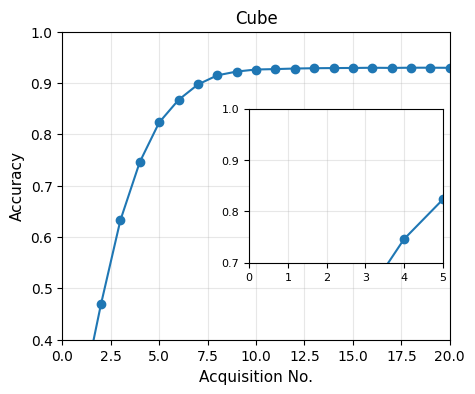

Mean Accuracy over all acquisitions = 0.8389


In [ ]:
result = np.array(result)

# 1. 각 내부 리스트 평균
row_means = result.mean(axis=1)
overall_mean = row_means.mean()

# 2. 표준편차
std = row_means.std()

# 3. index별 평균
col_means = result.mean(axis=0)

print("전체 평균(accuracy):", overall_mean)
print("표준편차:", std)
print("index별 평균(accuracy):", col_means)

# 시각화
plt.figure(figsize=(5,4))
plt.plot([i for i in range(1, D+1)], col_means, marker='o')
plt.xlabel('Acquisition No.', fontsize=11)
plt.ylabel('Accuracy', fontsize=11)
plt.title('Cube', fontsize=12)
plt.xlim(0, 20)
plt.ylim(0.4, 1.0)
plt.grid(True, alpha=0.3)

# 확대 영역
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = plt.gca()
axins = inset_axes(ax, width="50%", height="50%", loc='center right')

axins.plot([i for i in range(1, D+1)], col_means, marker='o')
axins.set_xlim(0, 5)
axins.set_ylim(0.7, 1.00)
axins.grid(True, alpha=0.3)
axins.tick_params(labelsize=8)

plt.show()

mean_acc = np.nanmean(accs)
print(f"Mean Accuracy over all acquisitions = {mean_acc:.4f}")

### Partial VAE

In [ ]:
predictor = Predictor(feature_dim=20, num_classes=8, hidden_dim=32)

pvae = PartialVAE(
    input_type="continuous",
    num_con_features=20,
    num_cat_features=0,
    hidden_dim_con=128,
    most_categories=max(1, 0),   # 내부 차원 계산을 위해 최소 1
    c_dim=32,
    hid_enc=128,
    hid_dec=128,
    latent_dim=16
).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 256
epochs = 10
lr = 1e-3
weight_decay = 1e-4

D = 20  # feature 개수 고정
predictor = predictor.to(device)
optimizer = AdamW(predictor.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_pvae = AdamW(pvae.parameters(), lr=lr, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)

result = [] # 결과 저장용

for _ in range(1):
    # predictor training
    for epoch in range(epochs):
        predictor.train()
        total_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            m_np = sample_mask_uniform_K_per_sample(bs=xb.size(0), d=D, min_K=1, max_K=D)
            mb = torch.tensor(m_np, dtype=torch.float32, device=device)

            logits = predictor(xb, mb)
            loss = criterion(logits, yb)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(predictor.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        predictor.eval()
        with torch.no_grad():
            xv, yv = X_val.to(device), y_val.to(device)

            # 각 샘플마다 랜덤 K로 마스크 생성 (학습과 동일)
            m_np = sample_mask_uniform_K_per_sample(bs=xv.size(0), d=D, min_K=1, max_K=D)
            mv = torch.tensor(m_np, dtype=torch.float32, device=device)

            probs_val = predictor(xv, mv)
            preds = probs_val.argmax(dim=-1)
            acc = (preds == yv).float().mean().item()

    # Partial VAE training
    pvae.train()
    for ep in range(epochs):
        total_loss, total_kl, total_nll = 0.0, 0.0, 0.0
        count = 0
        for xb, _ in train_loader:
            xb = xb.to(device).float()
            bs = xb.size(0)
            m_np = sample_mask_uniform_K_per_sample(bs=bs, d=D, min_K=1, max_K=D)
            mb = torch.tensor(m_np, dtype=torch.float32, device=device)

            loss, logs = pvae.loss_func(xb, mb, obs_sigma=1.0, n_samples=1)

            optimizer_pvae.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(pvae.parameters(), 1.0)
            optimizer_pvae.step()

            total_loss += loss.item() * bs
            total_kl   += logs["KL"].item() * bs
            total_nll  += logs["NLL_X"].item() * bs
            count      += bs
        print(f"[PVAE ep {ep:02d}] loss={total_loss/count:.4f}  KL={total_kl/count:.4f}  NLL_X={total_nll/count:.4f}")

    predictor.eval()
    N = X_test.size(0)
    D = X_test.size(1)
    x_np = X_test.cpu().numpy()
    m_np = np.zeros((N, D), dtype=np.float32)

    accs = []
    for t in range(1, D+1):
        FA = FeatureAcquisition(
            x=x_np,
            m=m_np,
            generative_model=pvae,
            num_samples=10,
            predictor=predictor,
            alpha=1.0,
            gamma=0.5
        )
        m_np, selected = FA.acquire()
        with torch.no_grad():
            xv = X_test.to(device)
            mv = torch.tensor(m_np, dtype=torch.float32, device=device)
            logits = predictor(xv, mv)
            y_pred = logits.argmax(dim=-1).cpu().numpy()

        y_true = y_test.cpu().numpy()
        acc_t = accuracy_score(y_true, y_pred)
        accs.append(acc_t)
        print(f"Step {t} acc / {acc_t:.4f}")

    result.append(accs)

KeyboardInterrupt: 

전체 평균: 0.813805
표준편차: 0.0
index별 평균: [0.2814 0.4233 0.5523 0.6517 0.7482 0.8132 0.8629 0.8853 0.9022 0.9105
 0.9151 0.9184 0.9203 0.9232 0.9251 0.9257 0.9264 0.9274 0.929  0.9345]


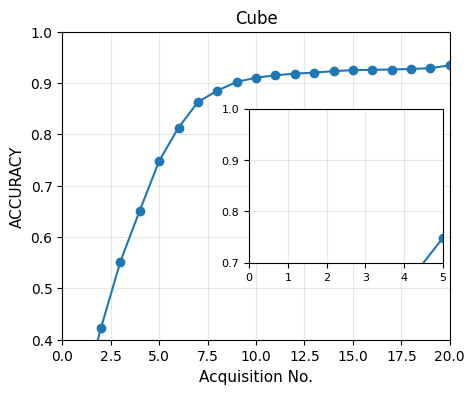

Mean ACC over all acquisitions = 0.8138


In [ ]:
result = np.array(result)

# 1. 각 내부 리스트 평균
row_means = result.mean(axis=1)
overall_mean = row_means.mean()

# 2. 표준편차
std = row_means.std()

# 3. index별 평균
col_means = result.mean(axis=0)

print("전체 평균:", overall_mean)
print("표준편차:", std)
print("index별 평균:", col_means)

# 시각화
plt.figure(figsize=(5,4))
plt.plot([i for i in range(1, D+1)], col_means, marker='o')
plt.xlabel('Acquisition No.', fontsize=11)
plt.ylabel('ACCURACY', fontsize=11)
plt.title('Cube', fontsize=12)
plt.xlim(0, 20)
plt.ylim(0.4, 1.0)
plt.grid(True, alpha=0.3)

# 확대 영역
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax = plt.gca()
axins = inset_axes(ax, width="50%", height="50%", loc='center right')

axins.plot([i for i in range(1, D+1)], col_means, marker='o')
axins.set_xlim(0, 5)
axins.set_ylim(0.7, 1.00)
axins.grid(True, alpha=0.3)
axins.tick_params(labelsize=8)

plt.show()

mean_auc = np.nanmean(accs)
print(f"Mean ACC over all acquisitions = {mean_auc:.4f}")

# Fashion MNIST